# ALFALFA Moment Maps

This notebook reads in an ALFALFA grid (all four spectra ranges) and weights and produces moment 8 maps (maps of the maximum intensity at any frequency along a line of sight), either for the four separate spectral ranges, and all four combined. 

It can also overlay optical detections from Durbala et al. 2020 by calling out to Vizier. 

You will need the ALFALFA grid in the directory you run this (or to edit the path to the .fits files). 

In [1]:
import copy
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from astroquery.vizier import Vizier

HI_restfreq = 1420405751.0 * u.Hz

In [2]:
# Function to average the two polarizations together and return a fits HDU object with the same header
def avg_pol(file):
    stokesI = np.mean(file[0].data,axis=0)
    new_file = fits.PrimaryHDU(data=stokesI,header=file[0].header)
    return new_file

In [3]:
# Function to make a mom0 map with the option to clip at a given sigma value.
# If the grid is an 'a' grid, only make a mom0 using the low frequency portion of the grid.
# Returns a 2-d array.

# *** NOT USED IN THIS NOTEBOOK, BUT SAVED FOR POSTERITY AS AN ALTERNATIVE ***
def simp_mom0(file,sigma=False):

    rms = np.sqrt(np.mean(np.square(file.data[300].flatten())))
    
    if file.header['CRVAL3'] > 1400:  # hopefully catches all "a" grids and not the others.
        if sigma:
            blanked_cube = np.where(np.abs(file.data[0:550]) > sigma*rms, file.data[0:550], 0.)
            mom0 = np.sum(blanked_cube,axis=0)
        else:
            mom0 = np.sum(file.data[0:550,:,:],axis=0)
        print("I think this is a grid a")
    else:
        if sigma:
            blanked_cube = np.where(np.abs(file.data) > sigma*rms, file.data, 0.)
            mom0 = np.sum(blanked_cube,axis=0)
        else:
            mom0 = np.sum(file.data,axis=0)
        print("grid b,c, or d")
    
    return mom0

In [4]:
# Function to make a mom8 map with the option to clip at a given sigma value.  Mom8 is the max value along freq axis.
# If the grid is an 'a' grid, only make a mom0 using the low frequency portion of the grid.
# Returns a 2-d array.

def simp_mom8(file,sigma=False):

    rms = np.sqrt(np.mean(np.square(file.data[300].flatten())))
    
    if file.header['CRVAL3'] > 1400:  # hopefully catches all "a" grids and not the others.
        mom8 = np.max(file.data[0:550,:,:],axis=0)
    else:
        mom8 = np.max(file.data,axis=0)
    
    return mom8

In [5]:
# Function to calculate the frequency associated with a velocity.  Both are in the heliocentric frame.
def vhelio2freq(vhelio):
    z = vhelio / const.c
    freq = HI_restfreq/(1+z)
    return freq.decompose().to(u.Hz)

In [6]:
# Read in the data cube
grida_hdu = fits.open('1044+13a_spectral.fits')
gridb_hdu = fits.open('1044+13b_spectral.fits')
gridc_hdu = fits.open('1044+13c_spectral.fits')
gridd_hdu = fits.open('1044+13d_spectral.fits')

In [7]:
# Read in the weights cube
wgtsa_hdu = fits.open('1044+13a_spectralweights.fits')
wgtsb_hdu = fits.open('1044+13b_spectralweights.fits')
wgtsc_hdu = fits.open('1044+13c_spectralweights.fits')
wgtsd_hdu = fits.open('1044+13d_spectralweights.fits')

In [8]:
# Normalize the data by the weights
grida_norm = copy.deepcopy(grida_hdu)
gridb_norm = copy.deepcopy(gridb_hdu)
gridc_norm = copy.deepcopy(gridc_hdu)
gridd_norm = copy.deepcopy(gridd_hdu)
grida_norm[0].data = grida_norm[0].data * wgtsa_hdu[0].data / np.max(wgtsa_hdu[0].data)
gridb_norm[0].data = gridb_norm[0].data * wgtsb_hdu[0].data / np.max(wgtsb_hdu[0].data)
gridc_norm[0].data = gridc_norm[0].data * wgtsc_hdu[0].data / np.max(wgtsc_hdu[0].data)
gridd_norm[0].data = gridd_norm[0].data * wgtsd_hdu[0].data / np.max(wgtsd_hdu[0].data)

In [9]:
# Get the spatial wcs information
alfalfa_wcs = WCS(grida_hdu[0].header,naxis=2)

In [10]:
# Optional: plot the location of the galaxies
# Open Durbala+2020 tables from CDS
durb1 = Vizier(catalog="J/AJ/160/271/table1", columns=['*', '_RAJ2000', '_DEJ2000'], row_limit=-1).query_constraints()[0]
durb2 = Vizier(catalog="J/AJ/160/271/table2", columns=['*', '_RAJ2000', '_DEJ2000'], row_limit=-1).query_constraints()[0]

durb1_coord = SkyCoord(durb1['_RAJ2000'],durb1['_DEJ2000'],unit='deg')

/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


<Figure size 640x480 with 0 Axes>

/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3

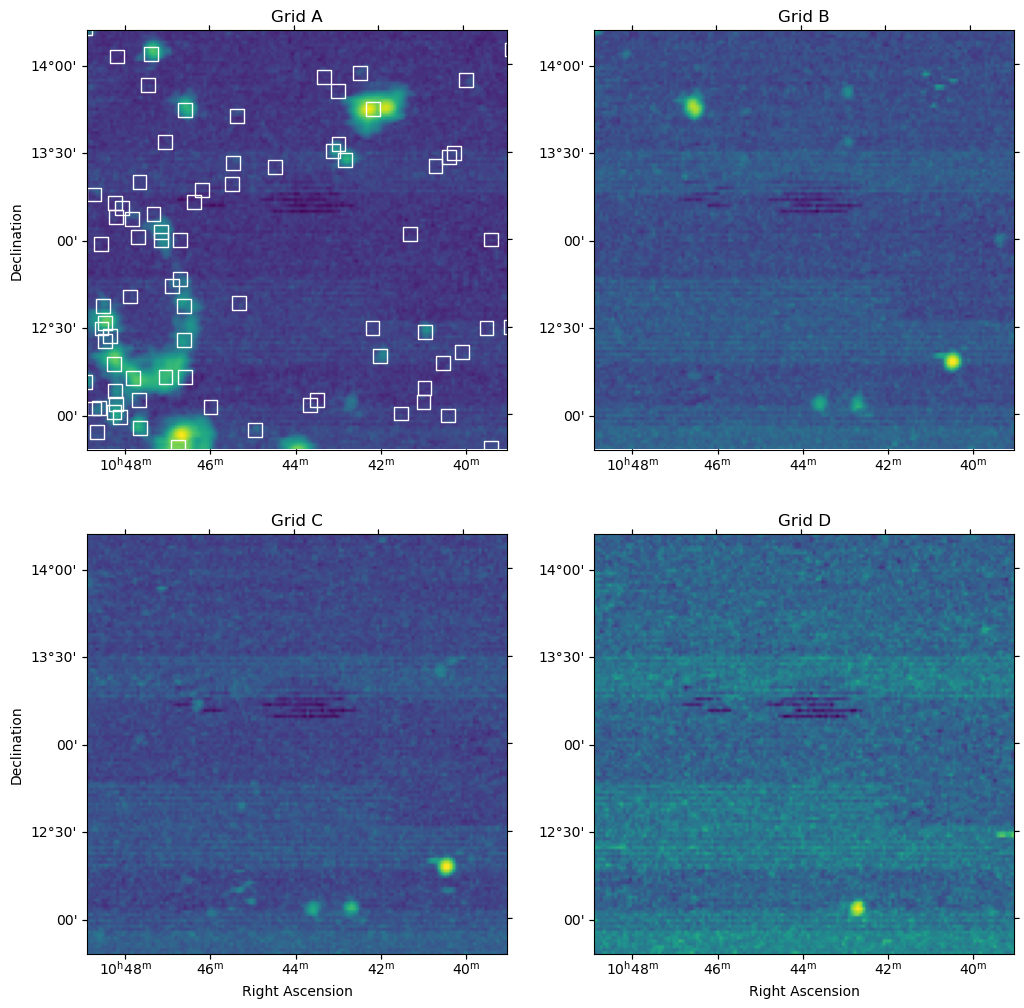

In [11]:
#

fig = plt.figure()
fig_im, ax_im = plt.subplots(2, 2, figsize=(12,12), subplot_kw={'projection': alfalfa_wcs}, squeeze=False)

durb1_freq = vhelio2freq(durb1['RVel'])

i,j,k = 0,0,0
for g,l in zip([grida_norm,gridb_norm,gridc_norm,gridd_norm],['Grid A','Grid B','Grid C','Grid D']):        
    grid = avg_pol(g)
    mom8 = simp_mom8(grid)
    fmin,fmax = g[0].header['CRVAL3'],g[0].header['CRVAL3']+g[0].header['CDELT3']*g[0].header['NAXIS3'] # COMMENT OUT IF NOT PLOTTING GALS
    durb1_subset = durb1_coord[(durb1_freq > fmin*u.MHz) & (durb1_freq < fmax*u.MHz)]                   # COMMENT OUT IF NOT PLOTTING GALS
    if i == 0:
        all_mom8 = mom8
    else:
        all_mom8 = np.concatenate((all_mom8,mom8))
    k = i
    if i >= 2:
        j,k = 1,i-2
    im = ax_im[j,k].imshow(mom8,norm=colors.LogNorm())
    ax_im[j,k].autoscale(False)
    ax_im[j,k].scatter_coord(durb1_subset,marker='s',color='white',facecolor='none',s=100)              # COMMENT OUT IF NOT PLOTTING GALS
    ax_im[j,k].set_title(l)
    if j==0:
        ax_im[j,k].coords[0].set_axislabel('')
        # ax_im[j,k].coords[0].set_ticklabel_visible(False)
    else:
        ax_im[j,k].coords[0].set_axislabel('Right Ascension')
    if k>=1:
        ax_im[j,k].coords[1].set_axislabel('')
        # ax_im[j,k].coords[1].set_ticklabel_visible(False)
    else:
        ax_im[j,k].coords[1].set_axislabel('Declination')
    i+=1
all_mom8 = all_mom8.reshape(4,-1,np.shape(all_mom8)[-1])
all_mom8 = np.max(all_mom8, axis=0)

/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/opt/anaconda3/envs/AALegacy/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2605: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


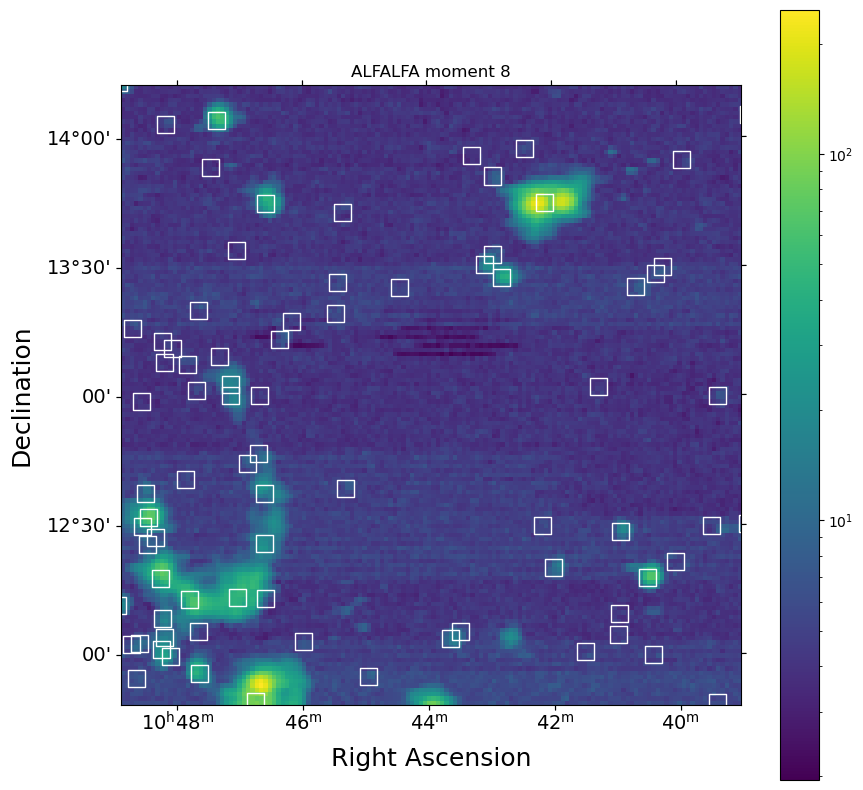

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=alfalfa_wcs)
im = ax.imshow(all_mom8,norm=colors.LogNorm())
ax.autoscale(False)
ax.scatter_coord(durb1_coord,marker='s',color='white',facecolor='none',s=150)
ax.coords[0].set_axislabel('Right Ascension',fontsize=18)
ax.coords[1].set_axislabel('Declination',fontsize=18)
ax.coords[0].set_ticklabel(size=14)
ax.coords[1].set_ticklabel(size=14)
ax.set_title('ALFALFA moment 8')
fig.colorbar(im)